In [1]:
#%pip install pyodbc  
#%pip install python-dotenv

#install openpyxl to overcome Import error of .xlsx file(Telco-churn-second-2000.xlsx)
#%pip install openpyxl

In [2]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
environment_variables=dotenv_values('.env')

database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
connection=pyodbc.connect(connection_string)

In [5]:
query="Select * from dbo.LP2_Telco_churn_first_3000"
data1=pd.read_sql(query, connection)

In [6]:
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
#get information on first dataset

data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [8]:
# Save extracted data as data1.csv

data1.to_csv('data1.csv')

In [9]:
#import second dataset and save as data2.csv

data2 = pd.read_csv(r"C:\Users\lenovo\Desktop\Seth\Personal\Azubi\Career Accelarator prog\LP2\LP2_Telco-churn-last-2000.csv")
data2.to_csv('data2.csv')

In [10]:
#get information on data2

data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [11]:
#check the shape of data 

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [12]:
data1.shape

(3000, 21)

In [13]:
data2.shape

(2043, 21)

In [14]:
# Compare the two DataFrames data1 and data2 side-by-side

# Create custom summary DataFrames for each DataFrame
summary_data1 = pd.DataFrame({'Column Name': data1.columns, 'Data Type': data1.dtypes, 'Non-Null Count': data1.count()})
summary_data2 = pd.DataFrame({'Column Name': data2.columns, 'Data Type': data2.dtypes, 'Non-Null Count': data2.count()})

# Set 'Column Name' as the index for both summary DataFrames
summary_data1.set_index('Column Name', inplace=True)
summary_data2.set_index('Column Name', inplace=True)

# Concatenate the two summary DataFrames side by side
comparison = pd.concat([summary_data1, summary_data2], axis=1, keys=['DataFrame 1', 'DataFrame 2'])

# Print the side-by-side comparison
print(comparison)

                 DataFrame 1                DataFrame 2               
                   Data Type Non-Null Count   Data Type Non-Null Count
Column Name                                                           
customerID            object           3000      object           2043
gender                object           3000      object           2043
SeniorCitizen           bool           3000       int64           2043
Partner                 bool           3000      object           2043
Dependents              bool           3000      object           2043
tenure                 int64           3000       int64           2043
PhoneService            bool           3000      object           2043
MultipleLines         object           2731      object           2043
InternetService       object           3000      object           2043
OnlineSecurity        object           2349      object           2043
OnlineBackup          object           2349      object           2043
Device

From the above, we can see that data2 (shown in DataFrame 2) has no missing data. However, data1 (shown in DataFrame 1) has some missing data. Also, there are different data types. Still column names are the same. 

Data cleaning for these will be done side by side and column by column

In [15]:
#Preview data1 'customerID column

data1['customerID'].head()

0    7590-VHVEG
1    5575-GNVDE
2    3668-QPYBK
3    7795-CFOCW
4    9237-HQITU
Name: customerID, dtype: object

In [16]:
#Preview data2 'customerID column

data2['customerID'].head()

0    5600-PDUJF
1    8292-TYSPY
2    0567-XRHCU
3    1867-BDVFH
4    2067-QYTCF
Name: customerID, dtype: object

Both 'customerID' columns look good. 
Preview 'gender' column of both data and clean if there are inconsistencies

In [17]:
data1['gender'].head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: gender, dtype: object

In [18]:
data1['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [19]:
data2['gender'].head()

0      Male
1      Male
2    Female
3      Male
4    Female
Name: gender, dtype: object

In [20]:
data2['gender'].unique()

array(['Male', 'Female'], dtype=object)

The 'gender' column for both data looks clean. 
Next we look at the 'SeniorCitizen' column for inconsistencies and possible cleaning. 
There are no missing data but the datatype is different. data1 is a boolean while data2 is integers

In [21]:
data1['SeniorCitizen'].unique()

array([False,  True])

In [22]:
data2['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [23]:
# Convert the binary column to boolean datatype
data2['SeniorCitizen'] = data2['SeniorCitizen'].astype(bool)

In [24]:
data2['SeniorCitizen'].unique()

array([False,  True])

The 'SeniorCitizen' column is clean now.
Check 'Partner' column
Convert data2['Partner'] to boolean datatype

In [25]:
data2['Partner'].head()

0     No
1     No
2    Yes
3    Yes
4    Yes
Name: Partner, dtype: object

In [26]:
data1['Partner'].head()

0     True
1    False
2    False
3    False
4    False
Name: Partner, dtype: bool

In [27]:
data2['Partner'].unique()

array(['No', 'Yes'], dtype=object)

In [28]:
#Replace 'Yes' or 'No' with True or False

data2['Partner'].replace('Yes', True, inplace=True)
data2['Partner'].replace('No', False, inplace=True)
data2['Partner'].head()

0    False
1    False
2     True
3     True
4     True
Name: Partner, dtype: bool

Check 'Dependent' column of inconsistencies. 

In [29]:
data1['Dependents'].head()

0    False
1    False
2    False
3    False
4    False
Name: Dependents, dtype: bool

In [30]:
data1['Dependents'].unique()

array([False,  True])

In [31]:
data2['Dependents'].head()

0     No
1     No
2    Yes
3    Yes
4     No
Name: Dependents, dtype: object

In [32]:
#Replace 'Yes' or 'No' with True or False

data2['Dependents'].replace('Yes', True, inplace=True)
data2['Dependents'].replace('No', False, inplace=True)
data2['Dependents'].head()

0    False
1    False
2     True
3     True
4    False
Name: Dependents, dtype: bool

Inconsistencies in 'Dependents' column resolved
Check 'tenure' for inconsistencies

In [33]:
data1['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [34]:
data2['tenure'].unique()

array([ 6, 19, 69, 11, 64, 39, 15, 25, 66, 61, 43, 12, 23, 71, 34,  5, 41,
       72, 14,  1, 10,  7,  9, 48, 20, 16,  2, 22, 35, 54, 56, 18, 68, 53,
       30, 36, 55, 21, 33, 44,  4, 49, 42, 67, 40, 45, 57,  8, 65,  3, 17,
       28, 52, 47, 50, 46, 29, 27, 13, 24, 62, 26, 60, 51, 70, 59, 38, 37,
        0, 58, 31, 32, 63], dtype=int64)

The 'tenure' column looks okay
Check 'PhoneService' column for inconsistencies

In [35]:
data1['PhoneService'].head()

0    False
1     True
2     True
3    False
4     True
Name: PhoneService, dtype: bool

In [36]:
data2['PhoneService'].head()

0    Yes
1    Yes
2     No
3    Yes
4    Yes
Name: PhoneService, dtype: object

In [37]:
#Replace 'Yes' or 'No' with True or False

data2['PhoneService'].replace('Yes', True, inplace=True)
data2['PhoneService'].replace('No', False, inplace=True)
data2['PhoneService'].head()

0     True
1     True
2    False
3     True
4     True
Name: PhoneService, dtype: bool

Inconsistencies in 'PhoneService' resolved
Check 'MultipleLines' for inconsistencies
data1 has some missing values

In [38]:
#confirm number of missing values

data1['MultipleLines'].isnull().sum()

269

In [39]:
data1['MultipleLines'].unique()

array([None, False, True], dtype=object)

In [40]:
data1['MultipleLines'].value_counts()

MultipleLines
False    1437
True     1294
Name: count, dtype: int64

In [41]:
#impute missing values with mode
mode_multiplelines = data1['MultipleLines'].mode()[0]

data1['MultipleLines'].fillna(mode_multiplelines, inplace=True)
data1['MultipleLines'].isnull().sum()


0

In [42]:
data1['MultipleLines'].value_counts()

MultipleLines
False    1706
True     1294
Name: count, dtype: int64

In [43]:
data2['MultipleLines'].unique()

array(['No', 'No phone service', 'Yes'], dtype=object)

In [44]:
data2['MultipleLines'].head()

0                  No
1                  No
2    No phone service
3                 Yes
4                 Yes
Name: MultipleLines, dtype: object

In [45]:
data2['MultipleLines'].value_counts()

MultipleLines
No                  987
Yes                 836
No phone service    220
Name: count, dtype: int64

In [46]:
#we assume that an answer of 'No phone service' is the same as No, since a customer without phone service will have not need for multiplelines

# Replace 'No phone service' with 'No' in the 'MultipleLines' column
data2['MultipleLines'].replace('No phone service', 'No', inplace=True)
data2['MultipleLines'].value_counts()

MultipleLines
No     1207
Yes     836
Name: count, dtype: int64

In [47]:
#confirm number of missing values

data2['MultipleLines'].isnull().sum()

0

In [48]:
data2['MultipleLines'].value_counts()

MultipleLines
No     1207
Yes     836
Name: count, dtype: int64

In [49]:
data2['MultipleLines'].replace('Yes', True, inplace=True)
data2['MultipleLines'].replace('No', False, inplace=True)
data2['MultipleLines'].head()

0    False
1    False
2    False
3     True
4     True
Name: MultipleLines, dtype: bool

In [50]:
data2['MultipleLines'].value_counts()

MultipleLines
False    1207
True      836
Name: count, dtype: int64

In [51]:
data2['MultipleLines'].unique()

array([False,  True])

In [52]:
data1['MultipleLines'].unique()

array([False,  True])

Inconsistencies in 'MultipleLines' resolved
Check 'InternetService' column for inconsistencies

In [53]:
data1['InternetService'].isnull().sum()

0

In [54]:
data1['InternetService'].nunique()

3

In [55]:
data1['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [56]:
data2['InternetService'].nunique()

3

In [57]:
data1['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

'InternetService' column is clean
Check 'OnlineSecurity' column for inconsistencies

In [58]:
data1['OnlineSecurity'].unique()

array([False, True, None], dtype=object)

In [59]:
data1['OnlineSecurity'].value_counts()

OnlineSecurity
False    1478
True      871
Name: count, dtype: int64

In [60]:
data1['OnlineSecurity'].isnull().sum()

651

In [61]:
# We assume the missing data is a response to the third option 'No Internet'. Hence will fill missing with 'No Internet'
# Impute missing values with 'No Internet'.


data1['OnlineSecurity'].fillna('No Internet', inplace=True)
data1['OnlineSecurity'].value_counts()

OnlineSecurity
False          1478
True            871
No Internet     651
Name: count, dtype: int64

In [62]:
data2['OnlineSecurity'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [63]:
data2['OnlineSecurity'].value_counts()

OnlineSecurity
No                     1029
Yes                     585
No internet service     429
Name: count, dtype: int64

In [64]:
# Replace 'No internet service' with 'No Internet' in the 'MultipleLines' column
data2['OnlineSecurity'].replace('No internet service', 'No Internet', inplace=True)
data2['OnlineSecurity'].value_counts()

OnlineSecurity
No             1029
Yes             585
No Internet     429
Name: count, dtype: int64

Inconsistencies in 'OnlineSecurity' column resolved
Check inconsistencies in 'OnlineBackup' column

In [65]:
data1['OnlineBackup'].isnull().sum()

651

In [66]:
data1['OnlineBackup'].unique()

array([True, False, None], dtype=object)

In [67]:
data2['OnlineBackup'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [68]:
# Replace 'False' with 'No' and 'True' with 'Yes' the 'OnlineBackup' column
# Fill missing values with 'No Internet'

data1['OnlineBackup'].replace(True, 'Yes', inplace=True)
data1['OnlineBackup'].replace(False, 'No', inplace=True)

data1['OnlineBackup'].fillna('No Internet', inplace=True)
data1['OnlineBackup'].value_counts()


OnlineBackup
No             1320
Yes            1029
No Internet     651
Name: count, dtype: int64

In [69]:
# Replace 'No internet service' with 'No Internet'

data2['OnlineBackup'].replace('No internet service', 'No Internet', inplace=True)
data2['OnlineBackup'].unique()

array(['No', 'Yes', 'No Internet'], dtype=object)

In [70]:
data1['DeviceProtection'].unique()

array([False, True, None], dtype=object)

In [71]:
data1['DeviceProtection'].isnull().sum()

651

In [72]:
# Replace 'False' with 'No' and 'True' with 'Yes' the 'OnlineBackup' column
# Fill missing values with 'No Internet'

data1['DeviceProtection'].replace(True, 'Yes', inplace=True)
data1['DeviceProtection'].replace(False, 'No', inplace=True)

data1['DeviceProtection'].fillna('No internet service', inplace=True)
data1['DeviceProtection'].value_counts()

DeviceProtection
No                     1296
Yes                    1053
No internet service     651
Name: count, dtype: int64

In [73]:
data2['DeviceProtection'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [74]:
data1['TechSupport'].unique()

array([False, True, None], dtype=object)

In [75]:
data1['TechSupport'].replace(True, 'Yes', inplace=True)
data1['TechSupport'].replace(False, 'No', inplace=True)

data1['TechSupport'].fillna('No internet', inplace=True)
data1['TechSupport'].value_counts()

TechSupport
No             1476
Yes             873
No internet     651
Name: count, dtype: int64

In [76]:
data1['TechSupport'].isnull().sum()

0

In [77]:
data2['TechSupport'].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [78]:
data2['TechSupport'].replace('No internet service', 'No internet', inplace=True)
data2['TechSupport'].unique()

array(['Yes', 'No', 'No internet'], dtype=object)

In [79]:
data1['StreamingTV'].unique()

array([False, True, None], dtype=object)

In [80]:
data1['StreamingTV'].replace(True, 'Yes', inplace=True)
data1['StreamingTV'].replace(False, 'No', inplace=True)

data1['StreamingTV'].fillna('No internet service', inplace=True)
data1['StreamingTV'].value_counts()

StreamingTV
No                     1190
Yes                    1159
No internet service     651
Name: count, dtype: int64

In [81]:
data2['StreamingTV'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [82]:
data1['StreamingMovies'].unique()

array([False, True, None], dtype=object)

In [83]:
data1['StreamingMovies'].replace(True, 'Yes', inplace=True)
data1['StreamingMovies'].replace(False, 'No', inplace=True)

data1['StreamingMovies'].fillna('No internet service', inplace=True)
data1['StreamingMovies'].value_counts()

StreamingMovies
Yes                    1199
No                     1150
No internet service     651
Name: count, dtype: int64

In [84]:
data2['StreamingMovies'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [85]:
data1['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [86]:
data2['Contract'].unique()

array(['Month-to-month', 'Two year', 'One year'], dtype=object)

In [87]:
data1['PaperlessBilling'].unique()

array([ True, False])

In [88]:
data1['PaperlessBilling'].replace(True, 'Yes', inplace=True)
data1['PaperlessBilling'].replace(False, 'No', inplace=True)
data1['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [89]:
data2['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [90]:
data1['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [91]:
data2['PaymentMethod'].unique()

array(['Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Bank transfer (automatic)'], dtype=object)

In [92]:
data1['MonthlyCharges'].head()

0    29.850000
1    56.950001
2    53.849998
3    42.299999
4    70.699997
Name: MonthlyCharges, dtype: float64

In [93]:
#convert to 2 decimal places

data1['MonthlyCharges'] = data1['MonthlyCharges'].round(2)
data1['MonthlyCharges'].head()

0    29.85
1    56.95
2    53.85
3    42.30
4    70.70
Name: MonthlyCharges, dtype: float64

In [94]:
data2['MonthlyCharges'].head()

0     49.50
1     55.00
2     43.95
3     74.35
4    111.15
Name: MonthlyCharges, dtype: float64

In [95]:
data1['TotalCharges'].head()

0      29.850000
1    1889.500000
2     108.150002
3    1840.750000
4     151.649994
Name: TotalCharges, dtype: float64

In [96]:
data1['TotalCharges'] = data1['TotalCharges'].round(2)
data1['TotalCharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

In [97]:
data1['TotalCharges'].isnull().sum()

5

In [98]:
# Drop rows with any missing values in the TotalCharges column
data1.dropna(subset='TotalCharges', inplace=True)
data1['TotalCharges'].isnull().sum()

0

In [99]:
data1['TotalCharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

In [100]:
data2['TotalCharges'].head()

0     312.7
1    1046.5
2    2960.1
3     834.2
4    6953.4
Name: TotalCharges, dtype: object

In [101]:
# Convert the TotalCharges column to float datatype
data2['TotalCharges'] = pd.to_numeric(data2['TotalCharges'], errors='coerce').astype(float)

# Round the values to 2 decimal places
data2['TotalCharges'] = data2['TotalCharges'].round(2)
data2['TotalCharges'].head()


0     312.7
1    1046.5
2    2960.1
3     834.2
4    6953.4
Name: TotalCharges, dtype: float64

In [102]:
data1['Churn'].isnull().sum()

1

In [103]:
data1['Churn'].unique()

array([False, True, None], dtype=object)

In [104]:
# Drop rows with any missing values in the Churn column
data1.dropna(subset='Churn', inplace=True)
data1['Churn'].isnull().sum()

0

In [105]:
data1['Churn'].unique()

array([False, True], dtype=object)

In [106]:
data1['Churn'].replace(True, 'Yes', inplace=True)
data1['Churn'].replace(False, 'No', inplace=True)
data1['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [107]:
data2['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [108]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   bool   
 3   Partner           2043 non-null   bool   
 4   Dependents        2043 non-null   bool   
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   bool   
 7   MultipleLines     2043 non-null   bool   
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [109]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2994 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2994 non-null   object 
 1   gender            2994 non-null   object 
 2   SeniorCitizen     2994 non-null   bool   
 3   Partner           2994 non-null   bool   
 4   Dependents        2994 non-null   bool   
 5   tenure            2994 non-null   int64  
 6   PhoneService      2994 non-null   bool   
 7   MultipleLines     2994 non-null   bool   
 8   InternetService   2994 non-null   object 
 9   OnlineSecurity    2994 non-null   object 
 10  OnlineBackup      2994 non-null   object 
 11  DeviceProtection  2994 non-null   object 
 12  TechSupport       2994 non-null   object 
 13  StreamingTV       2994 non-null   object 
 14  StreamingMovies   2994 non-null   object 
 15  Contract          2994 non-null   object 
 16  PaperlessBilling  2994 non-null   object 
 17  

In [110]:
data1.to_csv('clean_data1.csv', index=False)
data2.to_csv('clean_data2.csv', index=False)

In [111]:
#combine data1 and data2 since they are the train dataset
#covert to csv file and store as 'train.csv'

df=pd.concat([data1,data2])
df.to_csv('train.csv', index=False)

In [117]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,False,DSL,False,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,False,False,False,45,False,False,DSL,True,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5037 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5037 non-null   object 
 1   gender            5037 non-null   object 
 2   SeniorCitizen     5037 non-null   bool   
 3   Partner           5037 non-null   bool   
 4   Dependents        5037 non-null   bool   
 5   tenure            5037 non-null   int64  
 6   PhoneService      5037 non-null   bool   
 7   MultipleLines     5037 non-null   bool   
 8   InternetService   5037 non-null   object 
 9   OnlineSecurity    5037 non-null   object 
 10  OnlineBackup      5037 non-null   object 
 11  DeviceProtection  5037 non-null   object 
 12  TechSupport       5037 non-null   object 
 13  StreamingTV       5037 non-null   object 
 14  StreamingMovies   5037 non-null   object 
 15  Contract          5037 non-null   object 
 16  PaperlessBilling  5037 non-null   object 
 17  

In [113]:
df['TotalCharges'].isnull().sum()

3

In [ ]:
df['TotalCharges']

In [14]:
#preview concatenated DataFrame

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [15]:

df.describe()

,tenure,MonthlyCharges
count,5043.000000,5043.000000
mean,32.576641,65.090214
std,24.529807,30.068133
min,0.000000,18.400000
25%,9.000000,35.775000
50%,29.000000,70.550003
75%,56.000000,90.050003
max,72.000000,118.650002


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [17]:
#unable to read test data, why?
#possible solution: add (r"file path"), double \\, or forward/
#df2=pd.read_csv(r"C:\Users\lenovo\Desktop\Seth\Personal\Azubi\Career Accelarator prog\LP2\Telco-churn-second-2000.xlsx")

#file_path=r"C:\Users\lenovo\Desktop\Seth\Personal\Azubi\Career Accelarator prog\LP2\Telco-churn-second-2000.xlsx"
#df2=pd.read_excel(file_path)

#file_path="C:\\Users\\lenovo\\Desktop\\Seth\\Personal\\Azubi\\Career Accelarator prog\\LP2\\Telco-churn-second-2000.xlsx"
#df2=pd.read_excel(file_path)

#file_path="C:/Users/lenovo/Desktop/Seth/Personal/Azubi/Career Accelarator prog/LP2/Telco-churn-second-2000.xlsx"
#df2=pd.read_excel(file_path)



In [18]:
#import test dataset (Telco-churn-second-2000.xlsx)

file_path="C:/Users/lenovo/Desktop/Seth/Personal/Azubi/Career Accelarator prog/LP2/Telco-churn-second-2000.xlsx"
df2=pd.read_excel(file_path)

In [19]:
#preview df2(test dataset)

df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [20]:
#check shape of df2

df2.shape

(2000, 20)

Since I observed that the shapes of the two DataFrames were different, I decided to compare the two side-by-side with the code below. This showed that the test dataset(df2) did not have column 'Churn' as df(train dataset)

In [21]:
# Compare the two DataFrames df and df2 side-by-side

# Create custom summary DataFrames for each DataFrame
summary_df = pd.DataFrame({'Column Name': df.columns, 'Data Type': df.dtypes, 'Non-Null Count': df.count()})
summary_df2 = pd.DataFrame({'Column Name': df2.columns, 'Data Type': df2.dtypes, 'Non-Null Count': df2.count()})

# Set 'Column Name' as the index for both summary DataFrames
summary_df.set_index('Column Name', inplace=True)
summary_df2.set_index('Column Name', inplace=True)

# Concatenate the two summary DataFrames side by side
comparison = pd.concat([summary_df, summary_df2], axis=1, keys=['DataFrame 1', 'DataFrame 2'])

# Print the side-by-side comparison
print(comparison)

                 DataFrame 1                DataFrame 2               
                   Data Type Non-Null Count   Data Type Non-Null Count
Column Name                                                           
customerID            object           5043      object         2000.0
gender                object           5043      object         2000.0
SeniorCitizen         object           5043       int64         2000.0
Partner               object           5043      object         2000.0
Dependents            object           5043      object         2000.0
tenure                 int64           5043       int64         2000.0
PhoneService          object           5043      object         2000.0
MultipleLines         object           4774      object         2000.0
InternetService       object           5043      object         2000.0
OnlineSecurity        object           4392      object         2000.0
OnlineBackup          object           4392      object         2000.0
Device

In [22]:
df['SeniorCitizen'].unique()

array([False, True], dtype=object)

In [23]:
df2['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

From the above comparison, column 'SeniorCitizen' was an object in df but an integer in df2. Using a .unique() it was observed that df['SeniorCitizen] is a boolean while df2['SeniorCitizen'] is a binary variable. 

df2 had no missing values
df has some missing values which should be investigated

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [25]:
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

Using the above code to count the missing values in each column in df. The following columns will have to be checked and cleaned if necessary
Churn, TotalCharges, MultipleLines, OnlineSecurity,OnlineBackup, DeviceProtection, TechSupport,StreamingTV, and StreamingMovies   

In [26]:
#check the row with missing column in 'Churn'

column_name = 'Churn'

# Filter rows with missing values in the specified column
rows_with_missing_in_column = df[df[column_name].isnull()]

# Now, rows_with_missing_in_column is a DataFrame containing only the rows with missing values in the specified column
print(rows_with_missing_in_column)

      customerID gender SeniorCitizen Partner Dependents  tenure PhoneService  \
2988  6295-OSINB   Male         False    True      False      72         True   

     MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
2988          True     Fiber optic           True  ...             True   

     TechSupport StreamingTV StreamingMovies  Contract PaperlessBilling  \
2988       False        True            True  Two year             True   

         PaymentMethod MonthlyCharges  TotalCharges Churn  
2988  Electronic check     109.650002       7880.25  None  

[1 rows x 21 columns]


In [27]:
#drop missing value in 'Churn' column

df=df.dropna(subset=['Churn'])
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 0
dtype: int64

In [28]:
#confirm if missing value has been dropped

df.shape

(5042, 21)

Clean TotalCharges column
It has been observed that TotalCharges in an object datatype. This should be changed to float to reflect the purpose of this column. And from the description given on columns, this is the total amount charged to the customer. 
Since there are missing values, we can't use .astype(float) hence we use .to_numeric() in order to preserve the missing values and use either mean or median to impute later. 

In [29]:
# Convert the object column to float, preserving missing values as NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Round the values to 2 decimal places
df['TotalCharges'] = df['TotalCharges'].round(2)

In [30]:
#check if 'TotalCharges' has been converted to float
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5042 non-null   object 
 1   gender            5042 non-null   object 
 2   SeniorCitizen     5042 non-null   object 
 3   Partner           5042 non-null   object 
 4   Dependents        5042 non-null   object 
 5   tenure            5042 non-null   int64  
 6   PhoneService      5042 non-null   object 
 7   MultipleLines     4773 non-null   object 
 8   InternetService   5042 non-null   object 
 9   OnlineSecurity    4391 non-null   object 
 10  OnlineBackup      4391 non-null   object 
 11  DeviceProtection  4391 non-null   object 
 12  TechSupport       4391 non-null   object 
 13  StreamingTV       4391 non-null   object 
 14  StreamingMovies   4391 non-null   object 
 15  Contract          5042 non-null   object 
 16  PaperlessBilling  5042 non-null   object 
 17  

In [31]:
#check number of missing values in 'TotalCharges' column

df['TotalCharges'].isnull().sum()

8

Check descriptive statistics on 'TotalCharges' column. This shows a mean of 2300.95 and a median of 1401.00. This indicates a skewness in the 'TotalCharges' data. 

In [32]:
df['TotalCharges'].describe()

count    5034.000000
mean     2300.954758
std      2268.346401
min        18.800000
25%       417.662500
50%      1401.000000
75%      3860.600000
max      8670.100000
Name: TotalCharges, dtype: float64

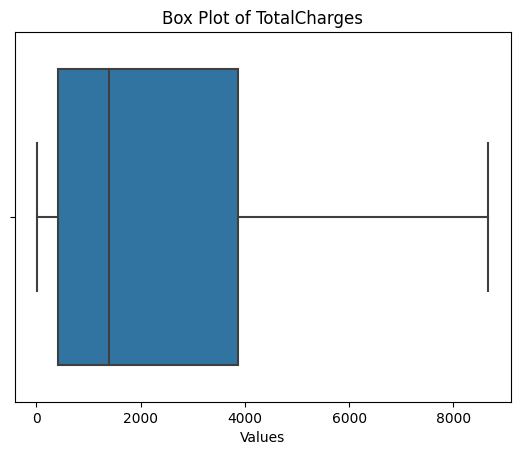

In [33]:
# Plot a box plot to visualize the distribution and skewness in 'TotalCharges' column

sns.boxplot(x=df['TotalCharges'])
plt.xlabel('Values')
plt.title('Box Plot of ' + 'TotalCharges')
plt.show()

Since there is skewness in the distribution, we choose to impute with the median which is less sensitive to extreme values.

In [34]:
# Impute missing values with the median

median_TotalCharges=df['TotalCharges'].median()

df['TotalCharges'].fillna(median_TotalCharges, inplace=True)

In [35]:
#check if missing value imputation was successful

df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

In [36]:
#check missing values hidden in strings in df2

df2[df2['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,
826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
1380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,


In [37]:
# Convert the object column to float, preserving missing values as NaN

df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')

# Round the values to 2 decimal places
df2['TotalCharges'] = df2['TotalCharges'].round(2)

In [38]:
#check again if there are any missing values in df2
#check if column was successfully converted to float

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [39]:
#count missing values in df2
#3 missing values detected in df2

df2['TotalCharges'].isnull().sum()

3

In [40]:
df2['TotalCharges'].describe()


count    1997.000000
mean     2235.995093
std      2259.794309
min        18.900000
25%       353.650000
50%      1388.450000
75%      3632.000000
max      8684.800000
Name: TotalCharges, dtype: float64

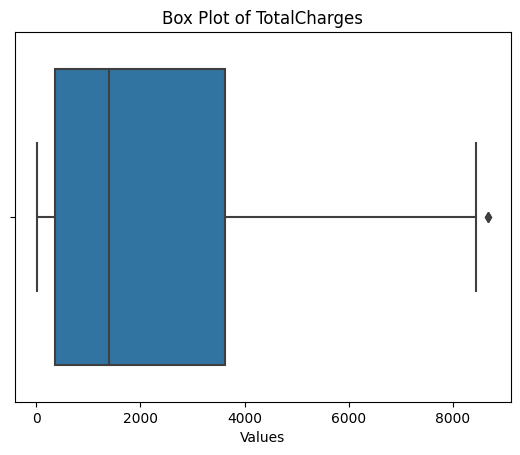

In [41]:
# Plot a box plot to visualize the distribution and skewness in 'TotalCharges' column

sns.boxplot(x=df2['TotalCharges'])
plt.xlabel('Values')
plt.title('Box Plot of ' + 'TotalCharges')
plt.show()

df2['TotalCharges'] column is skewed and has an outlier. Hence we impute missing values with median

In [42]:
# Impute missing values with the median

median_TotalCharges_2=df2['TotalCharges'].median()

df2['TotalCharges'].fillna(median_TotalCharges_2, inplace=True)

In [43]:
#confirm if missing values have been removed

df2['TotalCharges'].isnull().sum()

0

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5042 non-null   object 
 1   gender            5042 non-null   object 
 2   SeniorCitizen     5042 non-null   object 
 3   Partner           5042 non-null   object 
 4   Dependents        5042 non-null   object 
 5   tenure            5042 non-null   int64  
 6   PhoneService      5042 non-null   object 
 7   MultipleLines     4773 non-null   object 
 8   InternetService   5042 non-null   object 
 9   OnlineSecurity    4391 non-null   object 
 10  OnlineBackup      4391 non-null   object 
 11  DeviceProtection  4391 non-null   object 
 12  TechSupport       4391 non-null   object 
 13  StreamingTV       4391 non-null   object 
 14  StreamingMovies   4391 non-null   object 
 15  Contract          5042 non-null   object 
 16  PaperlessBilling  5042 non-null   object 
 17  

In [46]:
df['MultipleLines'].head()

0     None
1    False
2    False
3     None
4    False
Name: MultipleLines, dtype: object

In [47]:
df['MultipleLines'].value_counts()

MultipleLines
False               1437
True                1293
No                   987
Yes                  836
No phone service     220
Name: count, dtype: int64

In [53]:
df['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [54]:
#Replace 'Yes' or 'No' with True or False

df['MultipleLines'].replace('Yes', True, inplace=True)
df['MultipleLines'].replace('No', False, inplace=True)

In [55]:
df['MultipleLines'].value_counts()

MultipleLines
False               2424
True                2129
No phone service     220
Name: count, dtype: int64

In [56]:
df[df['MultipleLines']=='No phone service']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.10,No
13,1261-FWTTE,Male,1,No,No,23,No,No phone service,DSL,No,...,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),34.65,768.45,No
14,3528-HFRIQ,Male,1,Yes,No,71,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),52.30,3765.05,No
17,2073-QBVBI,Female,0,Yes,No,41,No,No phone service,DSL,No,...,No,Yes,No,No,One year,No,Mailed check,35.45,1391.65,No
34,9758-MFWGD,Female,1,Yes,Yes,48,No,No phone service,DSL,No,...,No,No,No,No,One year,No,Bank transfer (automatic),29.90,1388.75,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,4501-VCPFK,Male,0,No,No,26,No,No phone service,DSL,No,...,Yes,Yes,No,No,Month-to-month,No,Electronic check,35.75,1022.50,No
2007,2274-XUATA,Male,1,Yes,No,72,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),63.10,4685.55,No
2029,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.40,263.05,No
2036,7750-EYXWZ,Female,0,No,No,12,No,No phone service,DSL,No,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.65,743.30,No


In [57]:
df['MultipleLines'].unique()

array([None, False, True, 'No phone service'], dtype=object)

In [59]:
df['MultipleLines'].isnull().sum()

269

In [64]:
df['MultipleLines'].value_counts().sort_values

<bound method Series.sort_values of MultipleLines
False               2424
True                2129
No phone service     220
Name: count, dtype: int64>

Calculate percentage of missing values in 'MultipleLines' column

In [69]:
# Calculate the total number of rows in the column
total_rows = len(df)

# Calculate the number of missing values in the column
missing_values_count = df['MultipleLines'].isnull().sum()

# Calculate the percentage of missing values in the column
percentage_missing = (missing_values_count / total_rows) * 100
percentage_missing

5.335184450614835

Since the percentage of missing value is more that 5 percent, we shall impute missing data with 'False' because is the mode and also based on the information filled 'No phone service'

In [71]:
#calculate the mode of 'MultipleLines' column
#fill missing values with mode

mode_multiplelines = df['MultipleLines'].mode()[0]

df['MultipleLines'].fillna(mode_multiplelines, inplace=True)
df['MultipleLines'].isnull().sum()

0

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5042 non-null   object 
 1   gender            5042 non-null   object 
 2   SeniorCitizen     5042 non-null   object 
 3   Partner           5042 non-null   object 
 4   Dependents        5042 non-null   object 
 5   tenure            5042 non-null   int64  
 6   PhoneService      5042 non-null   object 
 7   MultipleLines     5042 non-null   object 
 8   InternetService   5042 non-null   object 
 9   OnlineSecurity    4391 non-null   object 
 10  OnlineBackup      4391 non-null   object 
 11  DeviceProtection  4391 non-null   object 
 12  TechSupport       4391 non-null   object 
 13  StreamingTV       4391 non-null   object 
 14  StreamingMovies   4391 non-null   object 
 15  Contract          5042 non-null   object 
 16  PaperlessBilling  5042 non-null   object 
 17  

In [74]:
df['OnlineSecurity'].isnull().sum()

651

In [75]:
# Filter and display rows with null values in the specified column
null_values_in_column = df[df['OnlineSecurity'].isnull()]

print(null_values_in_column)

              customerID  gender SeniorCitizen Partner Dependents  tenure  \
11            7469-LKBCI    Male         False   False      False      16   
16            8191-XWSZG  Female         False   False      False      52   
21            1680-VDCWW    Male         False    True      False      12   
22            1066-JKSGK    Male         False   False      False       1   
33            7310-EGVHZ    Male         False   False      False       1   
...                  ...     ...           ...     ...        ...     ...   
2984          6765-MBQNU  Female         False    True      False      26   
2987          3769-MHZNV  Female         False    True       True      33   
2989          3308-MHOOC    Male         False   False       True       1   
2993          2239-CFOUJ    Male         False    True       True       1   
2999  1A1:U3001038-RQOST    Male         False    True       True      19   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
11  

In [76]:
df['OnlineSecurity'].head()

0    False
1     True
2     True
3     True
4    False
Name: OnlineSecurity, dtype: object

In [77]:
df['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [78]:
df['OnlineSecurity'].nunique()

5

In [80]:
#replace 'Yes' or 'No' with True or False

df['OnlineSecurity'].replace('Yes', True, inplace=True)
df['OnlineSecurity'].replace('No', False, inplace=True)
df['OnlineSecurity'].unique()

array([False, True, None, 'No internet service'], dtype=object)

In [82]:
df['OnlineSecurity'].value_counts()

OnlineSecurity
False                  2507
True                   1455
No internet service     429
Name: count, dtype: int64

In [84]:
df['OnlineSecurity'].isnull().sum()

651